In [23]:
import seaborn as sns
import pandas as pd
import pandasql as ps
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import duckdb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

In [24]:
# Load configuration and data
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()
df.dtypes

timestamp             datetime64[ns, UTC]
message                            object
author                             object
has_emoji                            bool
is_topk                              bool
message_length                      int64
has_link                             bool
timestamp_category               category
hour                               object
day_of_week                         int32
msg_length                          int64
dtype: object

In [25]:
# --- Load metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

# Convert dictionary to a DataFrame
author_info_df = pd.DataFrame(nested_users).T.reset_index().rename(columns={'index': 'author'})

# --- Merge WhatsApp data with user info ---
df_merged = df.merge(author_info_df, on='author', how='left')

# df_merged["mentions_elevator"] = df_merged["message"].str.contains("lift", case=False, na=False)
df_merged.columns

Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length', 'Name', 'Gender', 'Entrance_nr', 'Unit_nr',
       'Floor_nr', 'Nr_rooms'],
      dtype='object')

In [26]:
print(df_merged.columns.tolist())


['timestamp', 'message', 'author', 'has_emoji', 'is_topk', 'message_length', 'has_link', 'timestamp_category', 'hour', 'day_of_week', 'msg_length', 'Name', 'Gender', 'Entrance_nr', 'Unit_nr', 'Floor_nr', 'Nr_rooms']


In [27]:
# Convert timestamp column if needed
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'], errors='coerce')

# Extract numeric hour
df_merged['hour'] = df_merged['timestamp'].dt.hour

print(df_merged.dtypes)


timestamp             datetime64[ns, UTC]
message                            object
author                             object
has_emoji                            bool
is_topk                              bool
message_length                      int64
has_link                             bool
timestamp_category               category
hour                                int32
day_of_week                         int32
msg_length                          int64
Name                               object
Gender                             object
Entrance_nr                        object
Unit_nr                            object
Floor_nr                           object
Nr_rooms                           object
dtype: object


In [28]:
print(df_merged.dtypes)


timestamp             datetime64[ns, UTC]
message                            object
author                             object
has_emoji                            bool
is_topk                              bool
message_length                      int64
has_link                             bool
timestamp_category               category
hour                                int32
day_of_week                         int32
msg_length                          int64
Name                               object
Gender                             object
Entrance_nr                        object
Unit_nr                            object
Floor_nr                           object
Nr_rooms                           object
dtype: object


In [ ]:
# Example: assuming df is your dataframe
numeric_cols = ['message_length', 'msg_length', 'hour', 'Entrance_nr', 
                'Unit_nr', 'Floor_nr', 'Nr_rooms']
categorical_cols = ['Gender', 'timestamp_category', 'day_of_week']
boolean_cols = ['has_emoji', 'is_topk', 'has_link']

# Preprocessing: scale numeric and one-hot encode categorical/boolean
# The ColumnTransformer in this context is used to preprocess different types of features in a DataFrame (df_merged) before further analysis or modeling.
# ColumnTransformer efficiently preprocesses different types of data into a single, usable format while applying appropriate transformations based on the data type.
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols + boolean_cols)
])

# Fit: In a scaler like StandardScaler, it calculates the mean and standard deviation for scaling numeric features.
# Transform: After fitting the model to the data, it then applies the learned parameters to transform the data into a new format. 
# This could involve scaling numeric values, encoding categorical variables, or any other transformation specified.
X = preprocessor.fit_transform(df_merged)

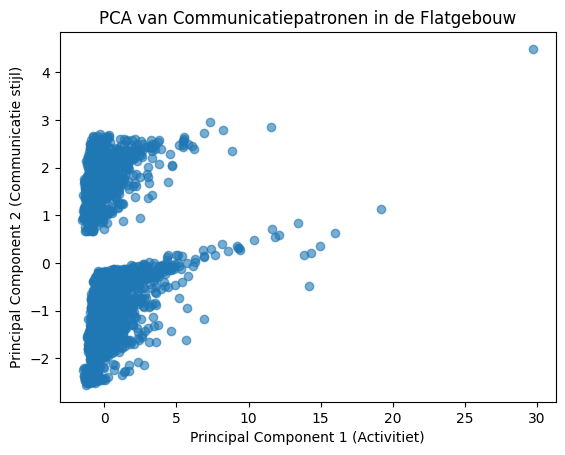

In [ ]:
# 6) Remove rows w/NaNs, do PCA, and plot
# Remove rows with NaN values in X
X_clean = X[~np.isnan(X).any(axis=1)]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
# plt.title('PCA of WhatsApp Group Communication Patterns')
plt.title('PCA van Communicatiepatronen in de Flatgebouw')
plt.xlabel('Principal Component 1 (Activitiet)')
plt.ylabel('Principal Component 2 (Communicatie stijl)')
plt.show()

In [31]:
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = tfidf.fit_transform(df['message'])

svd = TruncatedSVD(n_components=3)
X_svd = svd.fit_transform(X_tfidf)

for i, comp in enumerate(svd.components_):
    terms = [tfidf.get_feature_names_out()[j] for j in comp.argsort()[-10:]]
    print(f"Topic {i+1}: {', '.join(terms)}")

Topic 1: er, je, voor, dat, niet, van, en, ik, een, het
Topic 2: 12, 07, 2025, henk, herman, 2024, image, omitted, deleted, message
Topic 3: 07, 2025, wel, herman, 2024, je, image, henk, omitted, dank


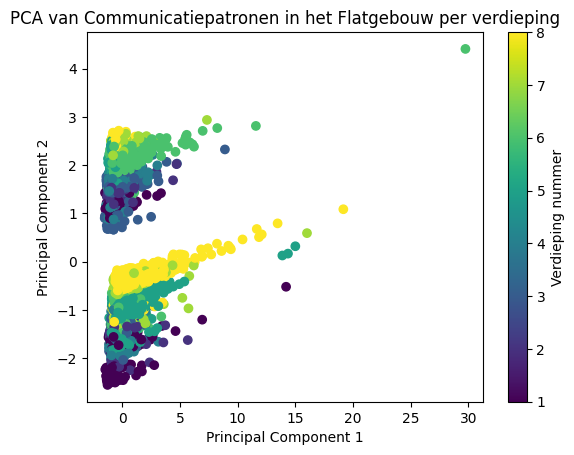

In [38]:
# Step 1: Identify which rows are kept after removing NaNs
mask = ~np.isnan(X).any(axis=1)

# Step 2: Apply the same mask to your original df
df_clean = df_merged.loc[mask].reset_index(drop=True)

# Step 3: Rebuild the TF-IDF + SVD on the same rows
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = tfidf.fit_transform(df_clean['message'])

svd = TruncatedSVD(n_components=3)
X_svd = svd.fit_transform(X_tfidf)

# Step 4: Combine
X_combined = np.hstack([X_pca, X_svd])

# Step 5: Continue with PCA
pca2 = PCA(n_components=2)
X_final = pca2.fit_transform(X_combined)

plt.scatter(X_final[:,0], X_final[:,1], c=df_clean['Floor_nr'], cmap='viridis')
plt.colorbar(label='Verdieping nummer')
# plt.title('Combined Communication + Text Patterns (PCA)')
plt.title('PCA van Communicatiepatronen in het Flatgebouw per verdieping')
# plt.xlabel('Principal Component 1 (Activitiet)')
plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2 (Communicatie stijl)')
plt.ylabel('Principal Component 2')
plt.show()


You could see if, for example:

Certain floors talk more about maintenance.

Certain time patterns (morning/night) correspond to particular topics.

In [33]:
# | Goal                             | Technique                    | Example Outcome                                |
# | -------------------------------- | ---------------------------- | ---------------------------------------------- |
# | Reduce message behavior features | PCA                          | Discover communication “archetypes”            |
# | Find latent text themes          | SVD (on TF-IDF)              | Identify discussion topics                     |
# | Combine both                     | PCA on numeric + SVD text    | Holistic user clusters                         |
# | Visualize clusters               | 2D PCA plot                  | Group tendencies (e.g., by floor, gender)      |
# | Time-based dynamics              | PCA per “timestamp_category” | See how conversation type shifts over day/week |
